In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)


from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, brier_score_loss
from xgboost import XGBClassifier
import dalex as dx
from yellowbrick.classifier import DiscriminationThreshold
from imblearn.over_sampling import SMOTE, SMOTENC


/home/np/PUT/V semester/AI/microscopic-epe-proj/.venv/lib/python3.13/site-packages/dalex/_global_checks.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
def train_and_evaluate_model(model, X, y, numerical_cols, categorical_cols, n_folds):
    y_pred_probs = np.array([])
    y_pred = np.array([])
    y_true = np.array([])

    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=2)

    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        num_pipeline = Pipeline(steps=[
            ('impute', SimpleImputer(strategy='median')),
            ('normalization', MinMaxScaler())
        ])
        cat_pipeline = Pipeline(steps=[
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
        ])
        preprocessor = ColumnTransformer(transformers=[
            ('num', num_pipeline, numerical_cols),
            ('cat', cat_pipeline, categorical_cols)
        ])
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        X_train_split, X_test_split = X.iloc[train_idx], X.iloc[test_idx]
        y_train_split, y_test_split = y.iloc[train_idx], y.iloc[test_idx]
        model_pipeline.fit(X_train_split, y_train_split)
        y_pred_prob_fold = model_pipeline.predict_proba(X_test_split)[:, 1]
        y_pred_fold = model_pipeline.predict(X_test_split)
        false_positive_rate, true_positive_rate, _ = roc_curve(y_test_split, y_pred_prob_fold)
        y_pred_probs = np.concatenate([y_pred_probs, y_pred_prob_fold])
        y_pred = np.concatenate([y_pred, y_pred_fold])
        y_true = np.concatenate([y_true, y_test_split])
        print(f"Fold {i}:")
        print(f"ROC AUC score: {roc_auc_score(y_test_split, y_pred_prob_fold)}\n")
    
    num_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='median')),
        ('normalization', MinMaxScaler())
    ])
    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, numerical_cols),
        ('cat', cat_pipeline, categorical_cols)
    ])
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    model_pipeline.fit(X, y)

    print(f"Total scores:")

    false_positive_rate, true_positive_rate, _ = roc_curve(y_true, y_pred_probs)
    total_roc_auc = roc_auc_score(y_true, y_pred_probs)
    print(f"ROC AUC score: {total_roc_auc}\n")
    return y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, model_pipeline

def plot_roc(false_positive_rate, true_positive_rate, total_roc_auc):
    plt.figure(figsize=(6,5))
    plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=2, label=f'ROC (AUC = {total_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred=None, y_pred_probs=None, threshold=0.5):
    if y_pred_probs is not None:
        y_pred = (np.array(y_pred_probs) >= threshold).astype(int)
    if y_pred is None:
        raise ValueError("Provide either y_pred or y_pred_probs")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion matrix (threshold={threshold})')
    plt.show()

def plot_feature_importances(model, X, y):
    explainer = dx.Explainer(model, X, y)
    importances = explainer.model_parts()
    importances.plot()

def plot_discrimination_threshold(model, X, y):
    visualizer = DiscriminationThreshold(model)
    visualizer.fit(X, y)
    visualizer.show()

# Train model

In [3]:
df = pd.read_csv('../materials/processed_df_new.csv')
df.head()

,ID,wiek,PSA,PSAdensity,MRI vol,MRI Pirads,MRI EPE,MRI EPE L,MRI EPE P,MRI SVI,MRI SVI L,MRI SVI P,MRI SIZE,Bx ISUP Grade P,Bx ISUP Grade L,ISUP RP,ISUP RP P,ISUP RP L,SM +,N +,EPE RP,EPE L RP,EPE P RP,SVI RP,SVI RP L,SVI RP P,TNM,EPE micro,EPE macro,EPE false_positive,Bx ISUP Grade
0,ID00000,63.0,5.11,0.146000,35.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,10.0,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2,0.0,0.0,1.0,1.0
1,ID00008,64.0,5.39,0.179667,30.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1,3.0,3.0,3.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,t3a,1.0,0.0,0.0,3.0
2,ID00500,64.0,8.30,0.207500,40.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2c,0.0,0.0,0.0,1.0
3,ID00001,56.0,6.80,0.200000,34.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,2,1.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2c,0.0,0.0,0.0,2.0
4,ID00002,59.0,40.00,2.222222,18.0,5.0,1.0,1.0,0.0,1.0,1.0,0.0,18.0,1,2.0,5.0,4.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,t3a,0.0,1.0,0.0,2.0


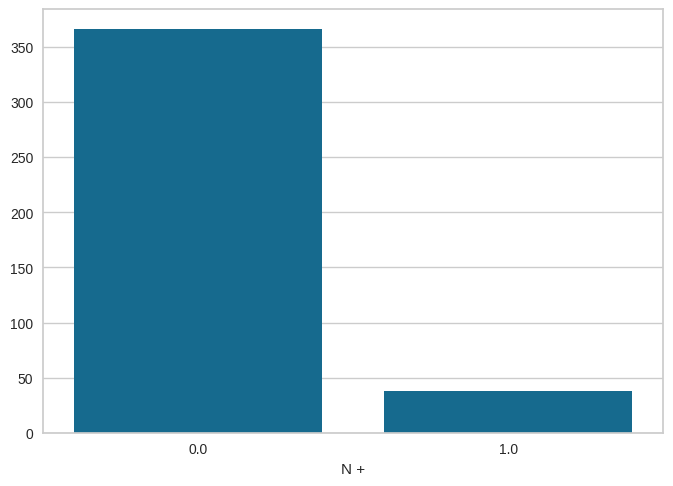

In [4]:
sns.barplot(x=df['N +'].value_counts().index, y=df['N +'].value_counts().values)
plt.xlabel('N +')
plt.show()

In [5]:
numerical_cols = ['wiek', 'PSA', 'PSAdensity', 'MRI vol', 'MRI SIZE']
categorical_cols = ['MRI Pirads', 'MRI EPE', 'MRI EPE L', 'MRI EPE P', 'MRI SVI', 'MRI SVI L', 'MRI SVI P', 'Bx ISUP Grade P', 'Bx ISUP Grade L', 'Bx ISUP Grade']

X = df[numerical_cols + categorical_cols]
y = df['N +']

Fold 0:
ROC AUC score: 0.8204633204633204

Fold 1:
ROC AUC score: 0.9006849315068494

Fold 2:
ROC AUC score: 0.9400684931506849

Fold 3:
ROC AUC score: 0.9058219178082192

Fold 4:
ROC AUC score: 0.821917808219178

Total scores:
ROC AUC score: 0.8783433994823123



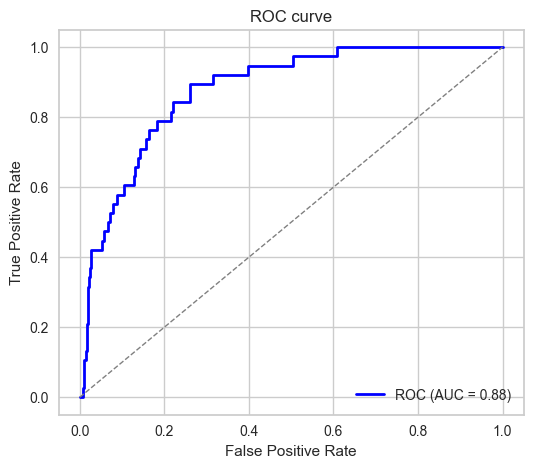

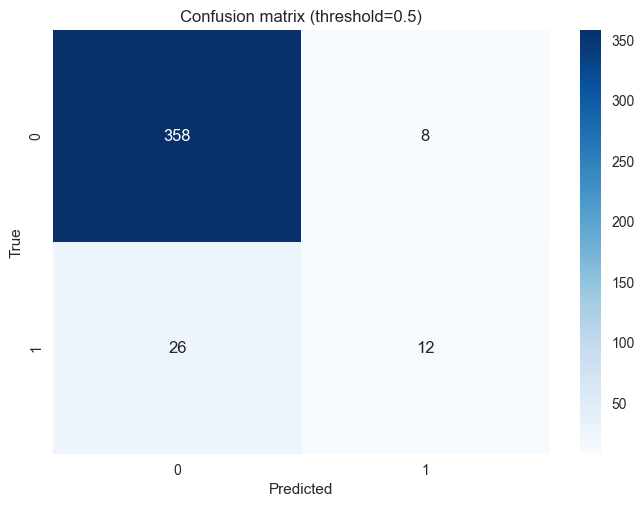

Preparation of a new explainer is initiated

  -> data              : 404 rows 15 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 404 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x00000254636F9DA0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000478, mean = 0.0943, max = 0.945
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.554, mean = -0.000281, max = 0.753
  -> model_info        : package sklearn

A new explainer has been created!


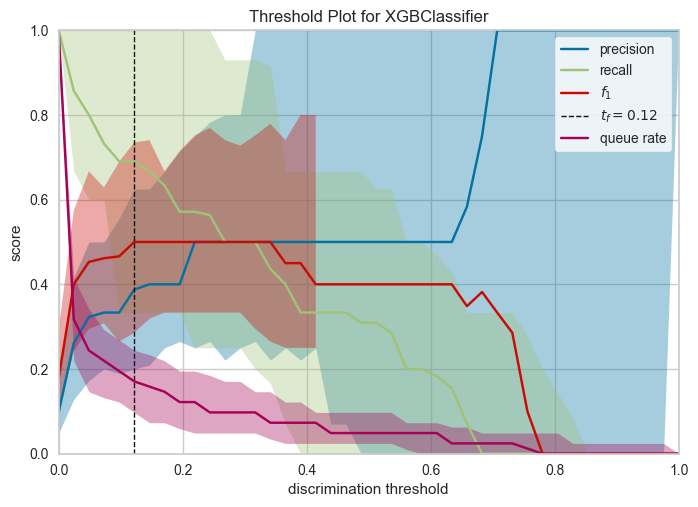

Brier score: 0.0695


In [ ]:
hyperparams = {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

untrained_model = XGBClassifier(random_state=42, **hyperparams)

y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, trained_model = train_and_evaluate_model(untrained_model, X, y, numerical_cols, categorical_cols, n_folds=5)
plot_roc(false_positive_rate, true_positive_rate, total_roc_auc)
plot_confusion_matrix(y_true, y_pred)
plot_feature_importances(trained_model, X, y)
plot_discrimination_threshold(untrained_model, X, y)
brier = brier_score_loss(y_true, y_pred_probs)
print(f"Brier score: {brier:.4f}")

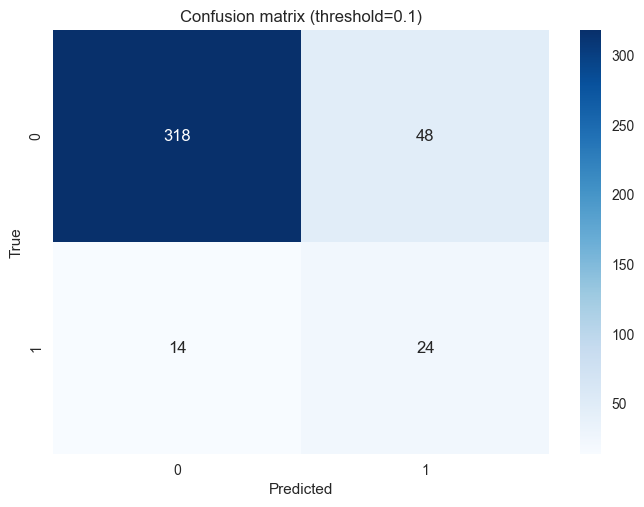

In [10]:
plot_confusion_matrix(y_true, y_pred_probs=y_pred_probs, threshold=0.1)

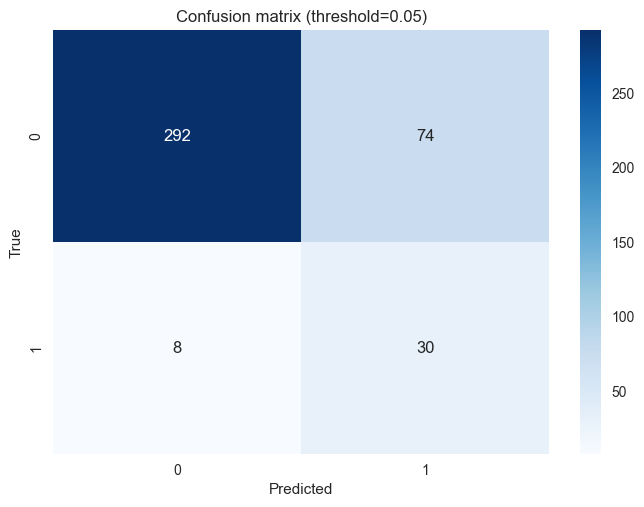

In [12]:
plot_confusion_matrix(y_true, y_pred_probs=y_pred_probs, threshold=0.05)

# Test SMOTE oversampling

In [14]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
])
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

preprocessor.fit(X)
X_imputed = preprocessor.transform(X)

In [15]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_imputed, y)
X_smote_df = pd.DataFrame(X_smote, columns=X.columns)

Fold 0:
ROC AUC score: 0.9772306553128471

Fold 1:
ROC AUC score: 0.9853757867456497

Fold 2:
ROC AUC score: 0.9831112779133045

Fold 3:
ROC AUC score: 0.9956839932445112

Fold 4:
ROC AUC score: 0.9898667667479828

Total scores:
ROC AUC score: 0.9869957299411747



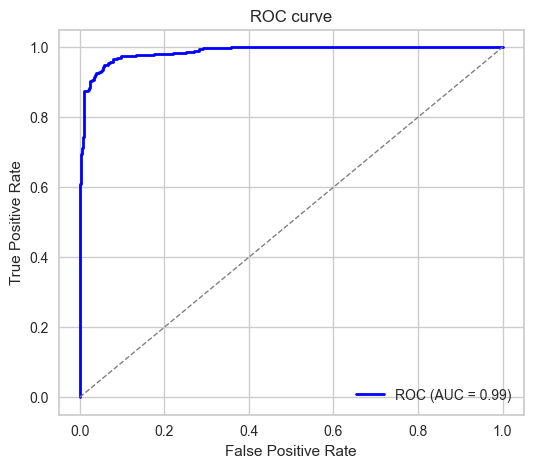

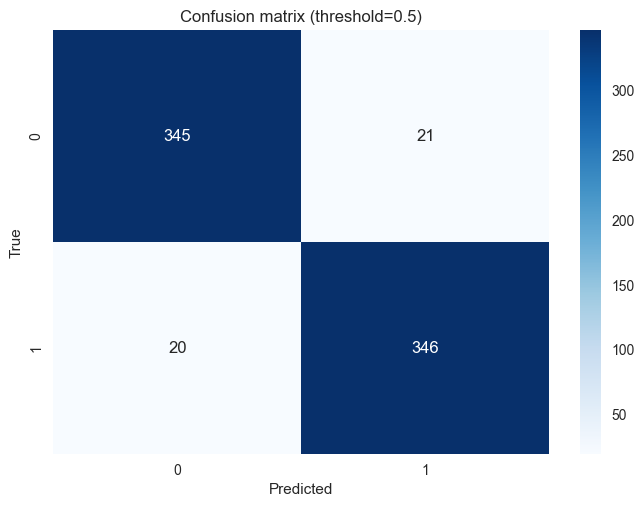

Preparation of a new explainer is initiated

  -> data              : 732 rows 15 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 732 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x00000254636F9DA0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00088, mean = 0.502, max = 0.998
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.638, mean = -0.00222, max = 0.735
  -> model_info        : package sklearn

A new explainer has been created!


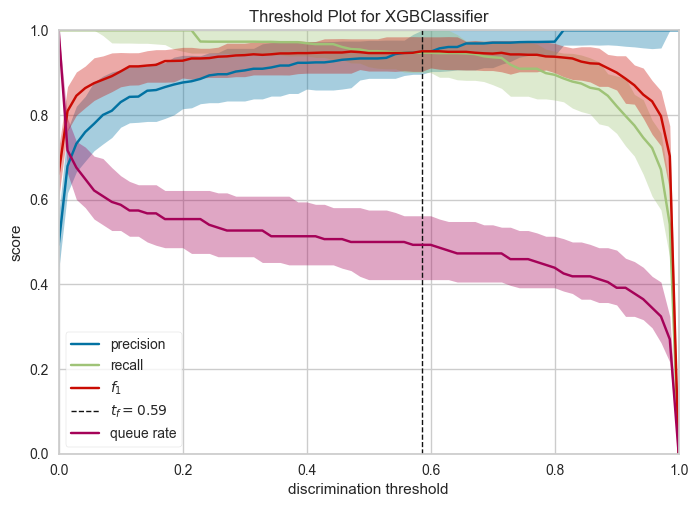

Brier score: 0.0425


In [16]:
hyperparams = {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

untrained_model = XGBClassifier(random_state=42, **hyperparams)

y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, trained_model = train_and_evaluate_model(untrained_model, X_smote_df, y_smote, numerical_cols, categorical_cols, n_folds=5)
plot_roc(false_positive_rate, true_positive_rate, total_roc_auc)
plot_confusion_matrix(y_true, y_pred)
plot_feature_importances(trained_model, X_smote_df, y_smote)
plot_discrimination_threshold(untrained_model, X_smote_df, y_smote)
brier = brier_score_loss(y_true, y_pred_probs)
print(f"Brier score: {brier:.4f}")

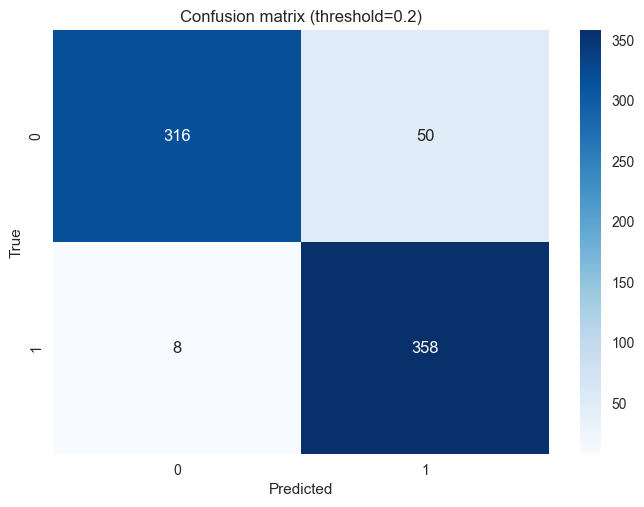

In [23]:
plot_confusion_matrix(y_true, y_pred_probs=y_pred_probs, threshold=0.2)

# Test SMOTENC

In [ ]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
])
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

preprocessor.fit(X)
X_imputed = preprocessor.transform(X)

In [ ]:
smote = SMOTENC(random_state=42, categorical_features=[X.columns.get_loc(col) for col in categorical_cols])
X_smote, y_smote = smote.fit_resample(X_imputed, y)
X_smote_df = pd.DataFrame(X_smote, columns=X.columns)

Fold 0:
ROC AUC score: 0.9768604220659015

Fold 1:
ROC AUC score: 0.9640873750462793

Fold 2:
ROC AUC score: 0.9778570088196659

Fold 3:
ROC AUC score: 0.9729780446612873

Fold 4:
ROC AUC score: 0.989116156877463

Total scores:
ROC AUC score: 0.9755068828570576



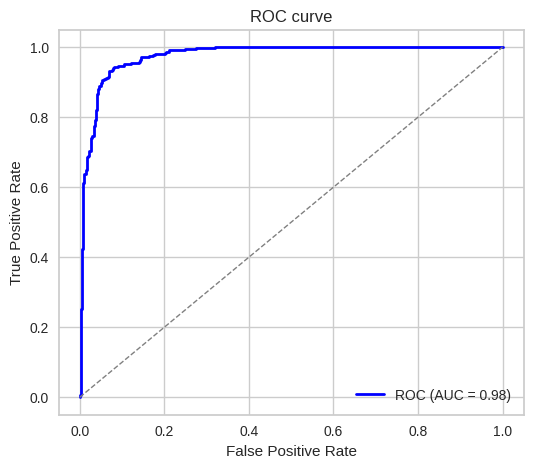

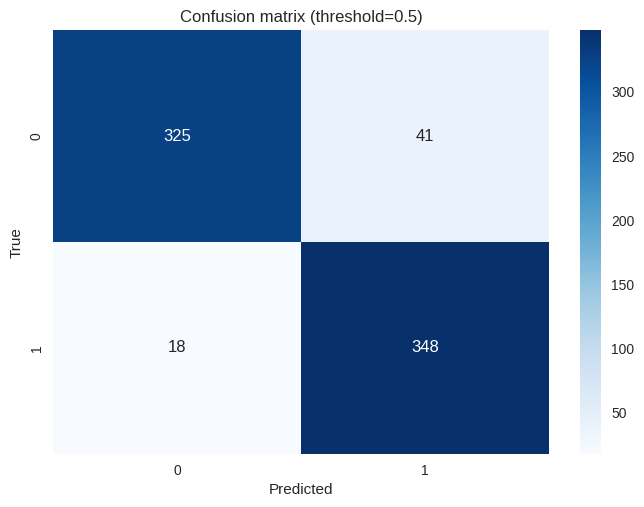

Preparation of a new explainer is initiated

  -> data              : 732 rows 15 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 732 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7da6e1162660> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00117, mean = 0.501, max = 0.995
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.864, mean = -0.00066, max = 0.86
  -> model_info        : package sklearn

A new explainer has been created!


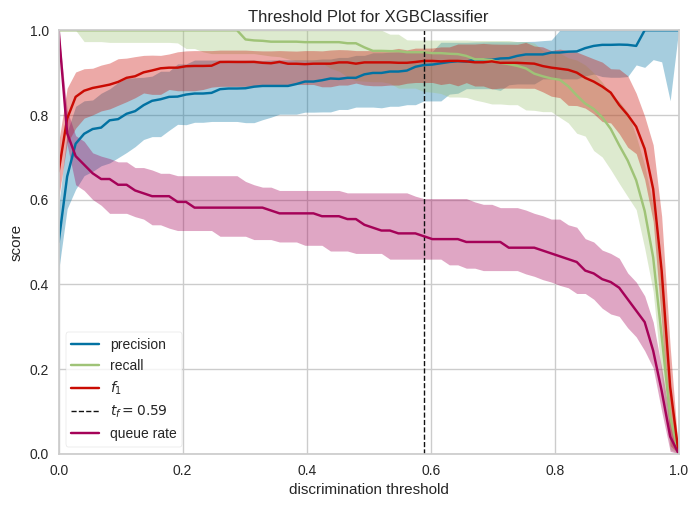

Brier score: 0.0574


In [ ]:
hyperparams = {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

untrained_model = XGBClassifier(random_state=42, **hyperparams)

y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, trained_model = train_and_evaluate_model(untrained_model, X_smote_df, y_smote, numerical_cols, categorical_cols, n_folds=5)
plot_roc(false_positive_rate, true_positive_rate, total_roc_auc)
plot_confusion_matrix(y_true, y_pred)
plot_feature_importances(trained_model, X_smote_df, y_smote)
plot_discrimination_threshold(untrained_model, X_smote_df, y_smote)
brier = brier_score_loss(y_true, y_pred_probs)
print(f"Brier score: {brier:.4f}")

# Optimizing XGBoost

### Maximize AUC

In [14]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])
grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)
print("Best hyperparameters:", grid_search.best_params_)


/home/linuxbrew/.linuxbrew/opt/python@3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/linuxbrew/.linuxbrew/opt/python@3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/linuxbrew/.linuxbrew/opt/python@3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025

Best hyperparameters: {'classifier__colsample_bytree': 1.0, 'classifier__gamma': 0.2, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


Fold 0:
ROC AUC score: 0.8262548262548263

Fold 1:
ROC AUC score: 0.8767123287671232

Fold 2:
ROC AUC score: 0.9246575342465753

Fold 3:
ROC AUC score: 0.9126712328767124

Fold 4:
ROC AUC score: 0.8669275929549902

Total scores:
ROC AUC score: 0.8769053781995974



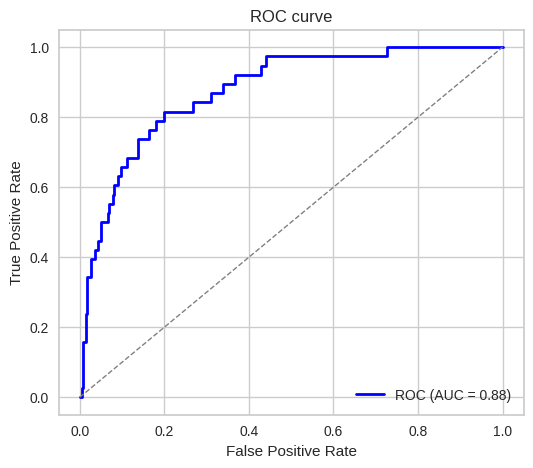

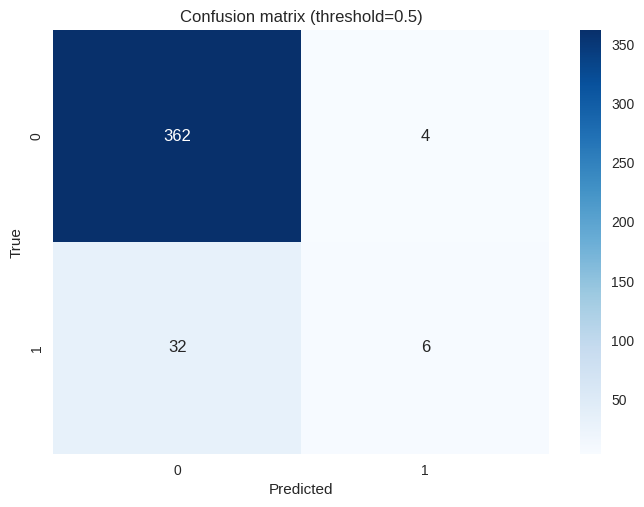

Preparation of a new explainer is initiated

  -> data              : 404 rows 15 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 404 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7da6e1162660> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0162, mean = 0.0898, max = 0.705
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.528, mean = 0.00431, max = 0.913
  -> model_info        : package sklearn

A new explainer has been created!


/home/np/PUT/V semester/AI/microscopic-epe-proj/.venv/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.



KeyboardInterrupt: 

In [17]:
hyperparams = {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

untrained_model = XGBClassifier(random_state=42, **hyperparams)

y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, trained_model = train_and_evaluate_model(untrained_model, X, y, numerical_cols, categorical_cols, n_folds=5)
plot_roc(false_positive_rate, true_positive_rate, total_roc_auc)
plot_confusion_matrix(y_true, y_pred)
plot_feature_importances(trained_model, X, y)
plot_discrimination_threshold(untrained_model, X, y)
brier = brier_score_loss(y_true, y_pred_probs)
print(f"Brier score: {brier:.4f}")

### Maximize brier score

In [ ]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])
grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, scoring='neg_brier_score', n_jobs=-1)
grid_search.fit(X_smote_df, y_smote)
print("Best hyperparameters:", grid_search.best_params_)


Best hyperparameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.6}


Fold 0:
ROC AUC score: 0.9803776379118845

Fold 1:
ROC AUC score: 0.989633469085524

Fold 2:
ROC AUC score: 0.9859260649277538

Fold 3:
ROC AUC score: 0.9960592981797711

Fold 4:
ROC AUC score: 0.9960592981797711

Total scores:
ROC AUC score: 0.9902729254382036



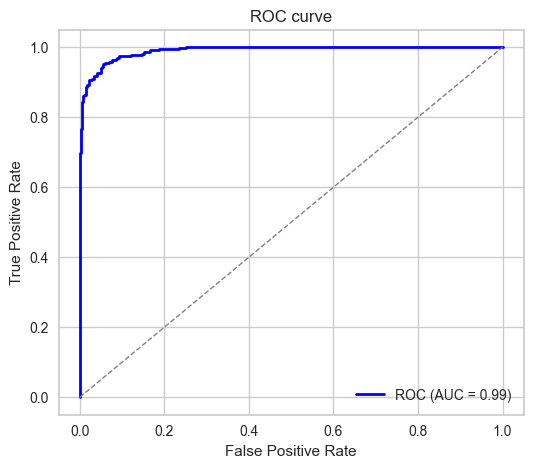

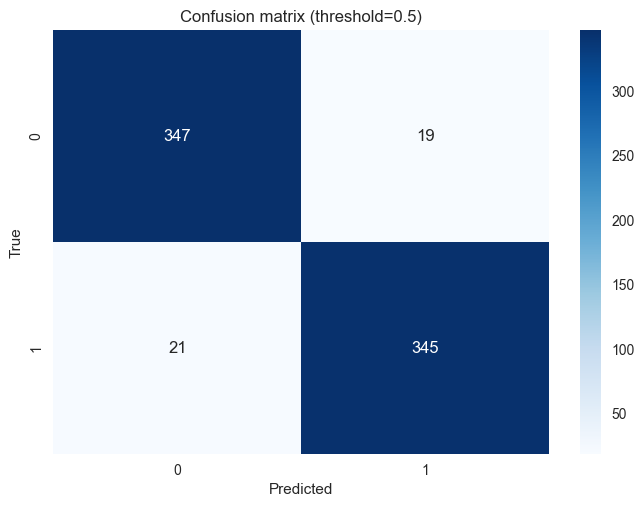

Preparation of a new explainer is initiated

  -> data              : 732 rows 15 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 732 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x00000254636F9DA0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00013, mean = 0.5, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.342, mean = -0.000399, max = 0.351
  -> model_info        : package sklearn

A new explainer has been created!


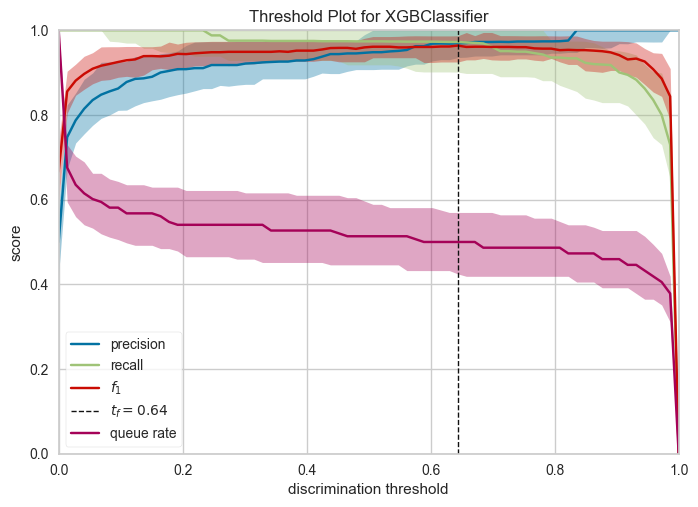

Brier score: 0.0400


In [ ]:
hyperparams = {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.6}

untrained_model = XGBClassifier(random_state=42, **hyperparams)

y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, trained_model = train_and_evaluate_model(untrained_model, X_smote_df, y_smote, numerical_cols, categorical_cols, n_folds=5)
plot_roc(false_positive_rate, true_positive_rate, total_roc_auc)
plot_confusion_matrix(y_true, y_pred)
plot_feature_importances(trained_model, X, y_smote)
plot_discrimination_threshold(untrained_model, X_smote_df, y_smote)
brier = brier_score_loss(y_true, y_pred_probs)
print(f"Brier score: {brier:.4f}")